In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
import pandas as pd
import sklearn

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data = pd.read_csv('/Users/gunnep/Downloads/corona_full_data.csv', parse_dates=['date'], index_col='date')
data.reset_index(inplace=True)

print(data.head(2))


        date     location  new_cases  new_deaths  total_cases  total_deaths
0 2019-12-31  Afghanistan          0           0            0             0
1 2020-01-01  Afghanistan          0           0            0             0


In [22]:
Italy = pd.DataFrame(data[data['location']=='Italy'])

In [4]:
Germany = pd.DataFrame(data[data['location']=='Germany'])

In [30]:
print(Italy)

           date location  new_cases  new_deaths  total_cases  total_deaths
2993 2019-12-31    Italy          0           0            0             0
2994 2020-01-01    Italy          0           0            0             0
2995 2020-01-02    Italy          0           0            0             0
2996 2020-01-03    Italy          0           0            0             0
2997 2020-01-04    Italy          0           0            0             0
...         ...      ...        ...         ...          ...           ...
3071 2020-03-18    Italy       3526         347        31506          2505
3072 2020-03-19    Italy       4207         473        35713          2978
3073 2020-03-20    Italy       5322         429        41035          3407
3074 2020-03-21    Italy       5986         625        47021          4032
3075 2020-03-22    Italy       6557         795        53578          4827

[83 rows x 6 columns]


In [5]:
China = pd.DataFrame(data[data['location']=='China'])

In [6]:
Korea = pd.DataFrame(data[data['location']=='South Korea'])

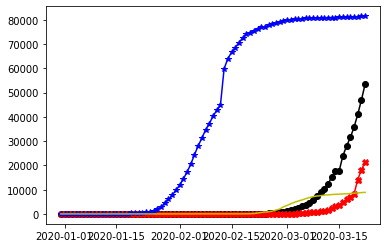

In [8]:
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot(Italy['date'],Italy['total_cases'], color='k',marker='o')
plt.plot(Germany['date'],Germany['total_cases'], color='r',marker='X')
plt.plot(China['date'],China['total_cases'], color='b',marker='*')
plt.plot(Korea['date'],Korea['total_cases'], color='y')

In [33]:
#Let's try to fit the two curves
from scipy import optimize

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

x_data = np.linspace(0, len(Italy), num=len(Italy))

params_exp, params_covariance_exp = optimize.curve_fit(exp_func, x_data,Italy['total_cases'],
                                               p0=[0.1, 0.1, 0.1])

print(params_exp)
print(params_covariance_exp)

[ 2.62873877e-01  1.47710487e-01 -2.60858575e+02]
[[ 1.56518006e-03 -7.36112823e-05 -1.47306937e+00]
 [-7.36112823e-05  3.46779480e-06  6.71313673e-02]
 [-1.47306937e+00  6.71313673e-02  6.75030369e+03]]


In [34]:
def log_func(x, a, b, c):
    return a / (1 + np.exp(c*(x + b)))

params_log, params_covariance_log = optimize.curve_fit(log_func, x_data,Italy['total_cases'],
                                               p0=[0.1, 0.1, 0.1])

print(params_log)
print(params_covariance_log)

[ 1.26862303e+05 -8.47454827e+01 -1.90445958e-01]
[[ 6.80475710e+07 -4.81156711e+03  2.84429633e+01]
 [-4.81156711e+03  3.42514179e-01 -2.06719092e-03]
 [ 2.84429633e+01 -2.06719092e-03  1.38212316e-05]]


/Users/gunnep/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


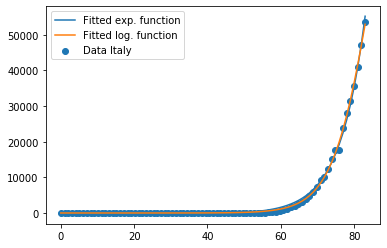

In [35]:
plt.figure(figsize=(6, 4))
plt.scatter(x_data, Italy['total_cases'], label='Data Italy')
plt.plot(x_data, exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]),
         label='Fitted exp. function')

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
         label='Fitted log. function')

plt.legend(loc='best')


In [36]:
#predictions of the new day
#Pessimistic
print(exp_func(len(Italy)+1, params_exp[0], params_exp[1], params_exp[2])-exp_func(len(Italy), params_exp[0], params_exp[1], params_exp[2]))
#Optimistic
print(log_func(len(Italy)+1, params_log[0], params_log[1], params_log[2])-log_func(len(Italy), params_log[0], params_log[1], params_log[2]))

8832.13977192725
5951.627140830518


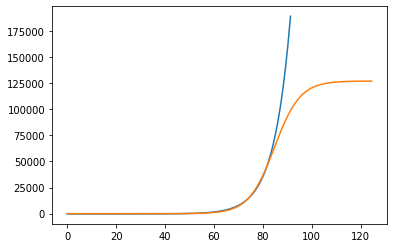

In [38]:
#Plot of the future
x_data = np.linspace(0, len(Italy)*1.1, num=len(Italy)*1.1)

plt.plot(x_data, exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]),
         label='Fitted exp. function')

x_data = np.linspace(0, len(Italy)*1.5, num=len(Italy)*1.5)

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
         label='Fitted log. function')

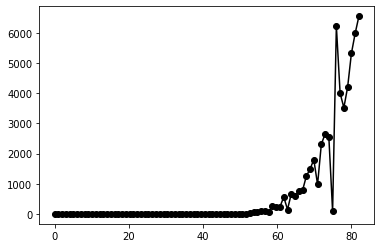

In [75]:
#Analysis of new cases
new_cases = []
indices = list(Italy.index)

for i in range(len(indices)-1):
    new_cases.append(int(Italy.iloc[i+1]['total_cases'])-int(Italy.iloc[i]['total_cases']))
        
new_cases = np.asarray(new_cases)
x_data = np.linspace(0, len(Italy)-1, num=len(Italy)-1)

plt.plot(x_data, new_cases, 
         label='New cases', color='k',marker='o')

In [12]:
def calculate_r2(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)

    print(r2)

In [13]:
calculate_r2(Italy['total_cases'],exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]))

0.9969708143573154


In [14]:
calculate_r2(Italy['total_cases'],log_func(x_data, params_log[0], params_log[1], params_log[2]))

0.9988876938561271


In [15]:
def fit_and_plot(country, china_bool=False):

    x_data = np.linspace(0, len(country), num=len(country))

    params_exp = []

    if(china_bool):
        print(params_exp)
    else:
        params_exp, params_covariance_exp = optimize.curve_fit(exp_func, x_data,country['total_cases'],
                                                       p0=[0.1, 0.1, 0.1])
    
    #print(params_exp)
    #print(params_covariance_exp)
    
    params_log, params_covariance_log = optimize.curve_fit(log_func, x_data,country['total_cases'],
                                               p0=[3.0, 0.1, 0.1])

    #print(params_log)
    #print(params_covariance_log)
    
    return params_exp,params_log,x_data

/Users/gunnep/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


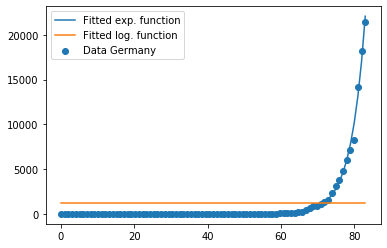

In [16]:
params_exp,params_log,x_data = fit_and_plot(Germany)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, Germany['total_cases'], label='Data Germany')
plt.plot(x_data, exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]),
                 label='Fitted exp. function')

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
                 label='Fitted log. function')

plt.legend(loc='best')

In [17]:
calculate_r2(Germany['total_cases'],exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]))
    
calculate_r2(Germany['total_cases'],log_func(x_data, params_log[0], params_log[1], params_log[2]))

0.9933336552940492
-2.220446049250313e-16


[]


/Users/gunnep/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


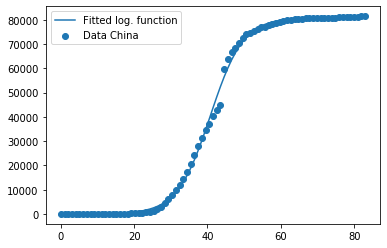

In [18]:
params_exp,params_log,x_data = fit_and_plot(China, True)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, China['total_cases'], label='Data China')

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
                 label='Fitted log. function')

plt.legend(loc='best')

In [19]:
calculate_r2(China['total_cases'],log_func(x_data, params_log[0], params_log[1], params_log[2]))

0.9982729786107419


In [20]:
params_exp,params_log,x_data = fit_and_plot(Korea)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, Korea['total_cases'], label='Data Korea')

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
                 label='Fitted log. function')

plt.plot(x_data, exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]),
                 label='Fitted exp. function')

plt.legend(loc='best')

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [186]:
calculate_r2(Korea['total_cases'],exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]))
    
calculate_r2(Korea['total_cases'],log_func(x_data, params_log[0], params_log[1], params_log[2]))

0.9430237052146274
0.9992102593697357
